In [ ]:
# Install required packages
!pip install --quiet gym==0.21.0 pyglet==1.5.27
!pip install --quiet torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install --quiet fpdf matplotlib tabulate


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
# Imports and device
import gym, math, random, os
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import torch, torch.nn as nn, torch.optim as optim
from fpdf import FPDF
from tabulate import tabulate

# Patch for NumPy >= 1.24 (some old gym versions reference np.bool8)
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Using device: cpu


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
def plot_learning_curve(rewards, title="Rewards", window=20):
    plt.figure(figsize=(8,4))
    plt.plot(rewards, label="Episode reward")
    if len(rewards) >= window:
        sm = np.convolve(rewards, np.ones(window)/window, mode="valid")
        plt.plot(range(window-1, len(rewards)), sm, label=f"Smoothed({window})")
    plt.xlabel("Episode"); plt.ylabel("Reward"); plt.title(title)
    plt.legend(); plt.grid(True); plt.show()

def evaluate_policy(env, policy_fn, episodes=10, max_steps=500):
    rewards = []
    for _ in range(episodes):
        s = env.reset()
        total = 0.0
        for _ in range(max_steps):
            a = policy_fn(s)
            s, r, done, _ = env.step(a)
            total += r
            if done:
                break
        rewards.append(total)
    return np.mean(rewards), np.std(rewards)


Training Q-Learning on MountainCar (this will take a few minutes)...


/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


[MC Q] Episode 200/1200  avg_last200=-200.00  eps=0.367
[MC Q] Episode 400/1200  avg_last200=-200.00  eps=0.135
[MC Q] Episode 600/1200  avg_last200=-197.31  eps=0.050
[MC Q] Episode 800/1200  avg_last200=-197.38  eps=0.050
[MC Q] Episode 1000/1200  avg_last200=-192.72  eps=0.050
[MC Q] Episode 1200/1200  avg_last200=-188.24  eps=0.050


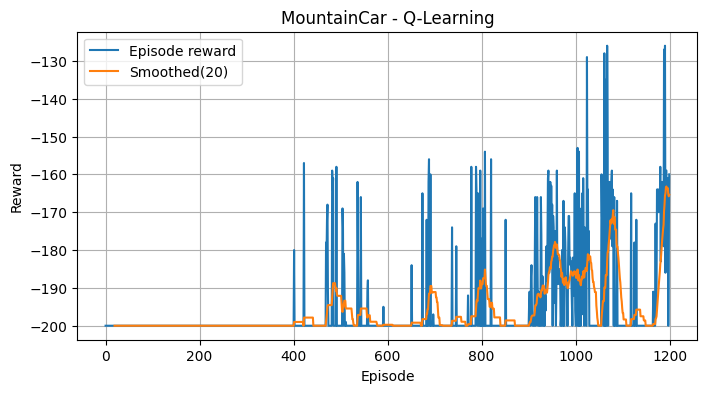

In [ ]:
# MountainCar Q-learning (tabular via discretization)
env = gym.make("MountainCar-v0")

n_bins = (18, 14)
pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], n_bins[0]-1)
vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], n_bins[1]-1)

def discretize(obs):
    pos, vel = obs
    return np.digitize(pos, pos_space), np.digitize(vel, vel_space)

n_actions = env.action_space.n
q_table = np.zeros(n_bins + (n_actions,))

alpha = 0.1
gamma = 0.99
epsilon = 1.0
min_epsilon = 0.05
decay = 0.995

def train_q_learning_mountaincar(episodes=1200, max_steps=200):
    global epsilon, q_table
    rewards = []
    for ep in range(episodes):
        s = env.reset()
        s_disc = discretize(s)
        total_r = 0.0
        for _ in range(max_steps):
            if random.random() < epsilon:
                a = env.action_space.sample()
            else:
                a = int(np.argmax(q_table[s_disc]))
            s2, r, done, _ = env.step(a)
            s2_disc = discretize(s2)
            q_table[s_disc + (a,)] += alpha * (r + gamma * np.max(q_table[s2_disc]) - q_table[s_disc + (a,)])
            s_disc = s2_disc
            total_r += r
            if done:
                break
        rewards.append(total_r)
        epsilon = max(min_epsilon, epsilon * decay)
        if (ep+1) % 200 == 0:
            print(f"[MC Q] Episode {ep+1}/{episodes}  avg_last200={np.mean(rewards[-200:]):.2f}  eps={epsilon:.3f}")
    return rewards

print("Training Q-Learning on MountainCar (this will take a few minutes)...")
mc_q_rewards = train_q_learning_mountaincar(episodes=1200, max_steps=200)
plot_learning_curve(mc_q_rewards, "MountainCar - Q-Learning")


Training DQN on MountainCar (short run)...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-1900741602.py:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  s_b = torch.tensor(batch.s, dtype=torch.float32, device=device)


[MC DQN] Episode 100/600  ep_reward=-200.00  eps=0.606
[MC DQN] Episode 200/600  ep_reward=-200.00  eps=0.367
[MC DQN] Episode 300/600  ep_reward=-200.00  eps=0.222
[MC DQN] Episode 400/600  ep_reward=-200.00  eps=0.135
[MC DQN] Episode 500/600  ep_reward=-200.00  eps=0.082
[MC DQN] Episode 600/600  ep_reward=-200.00  eps=0.050


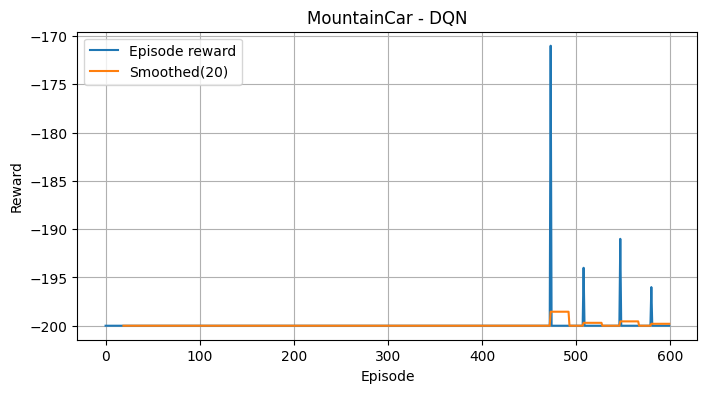

In [ ]:
# DQN network and replay buffer
class DQN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim)
        )
    def forward(self, x):
        return self.net(x)

Transition = namedtuple('Transition', ('s','a','r','s2','done'))
class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)
    def push(self, *args):
        self.buffer.append(Transition(*args))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))
    def __len__(self):
        return len(self.buffer)

def train_dqn_mountaincar(episodes=600, batch_size=64):
    env_local = gym.make("MountainCar-v0")
    state_dim = env_local.observation_space.shape[0]
    action_dim = env_local.action_space.n
    policy_net = DQN(state_dim, action_dim).to(device)
    target_net = DQN(state_dim, action_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
    buffer = ReplayBuffer(20000)
    epsilon = 1.0
    eps_end = 0.05
    eps_decay = 0.995
    rewards = []
    update_target_every = 50

    for ep in range(episodes):
        s = env_local.reset()
        ep_r = 0.0
        for _ in range(200):
            s_t = torch.tensor(s, dtype=torch.float32, device=device)
            if random.random() < epsilon:
                a = env_local.action_space.sample()
            else:
                with torch.no_grad():
                    qvals = policy_net(s_t)
                    a = int(torch.argmax(qvals).item())
            s2, r, done, _ = env_local.step(a)
            buffer.push(s, a, r, s2, done)
            s = s2
            ep_r += r

            if len(buffer) >= batch_size:
                batch = buffer.sample(batch_size)
                s_b = torch.tensor(batch.s, dtype=torch.float32, device=device)
                a_b = torch.tensor(batch.a, dtype=torch.int64, device=device).unsqueeze(1)
                r_b = torch.tensor(batch.r, dtype=torch.float32, device=device).unsqueeze(1)
                s2_b = torch.tensor(batch.s2, dtype=torch.float32, device=device)
                done_b = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)

                qvals = policy_net(s_b).gather(1, a_b)
                with torch.no_grad():
                    next_q = target_net(s2_b).max(1)[0].unsqueeze(1)
                expected = r_b + gamma * next_q * (1 - done_b)
                loss = nn.functional.mse_loss(qvals, expected)
                optimizer.zero_grad(); loss.backward(); optimizer.step()

            if done:
                break

        rewards.append(ep_r)
        epsilon = max(eps_end, epsilon * eps_decay)
        if (ep+1) % update_target_every == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if (ep+1) % 100 == 0:
            print(f"[MC DQN] Episode {ep+1}/{episodes}  ep_reward={ep_r:.2f}  eps={epsilon:.3f}")

    return policy_net, rewards

print("Training DQN on MountainCar (short run)...")
mc_dqn_model, mc_dqn_rewards = train_dqn_mountaincar(episodes=600, batch_size=64)
plot_learning_curve(mc_dqn_rewards, "MountainCar - DQN")


/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require 

Training Q-Learning on Roulette...
[Roulette Q] Ep 500, avg_last500=0.028
[Roulette Q] Ep 1000, avg_last500=0.108
[Roulette Q] Ep 1500, avg_last500=0.048
[Roulette Q] Ep 2000, avg_last500=0.096


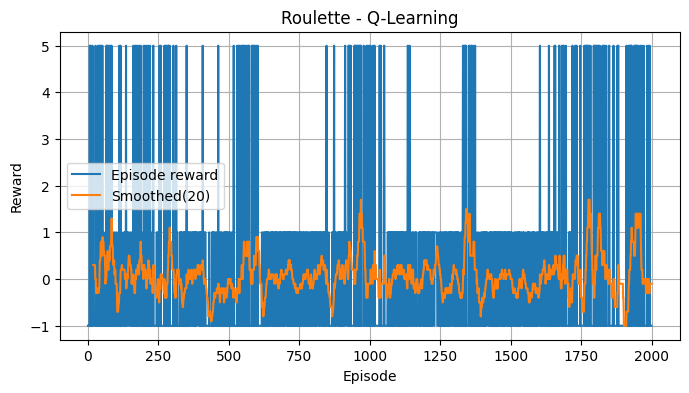

Training DQN on Roulette (short run)...
[Roulette DQN] Ep 200, last_r=1.00, eps=0.367
[Roulette DQN] Ep 400, last_r=-1.00, eps=0.135
[Roulette DQN] Ep 600, last_r=-1.00, eps=0.050
[Roulette DQN] Ep 800, last_r=-1.00, eps=0.050
[Roulette DQN] Ep 1000, last_r=1.00, eps=0.050
[Roulette DQN] Ep 1200, last_r=-1.00, eps=0.050


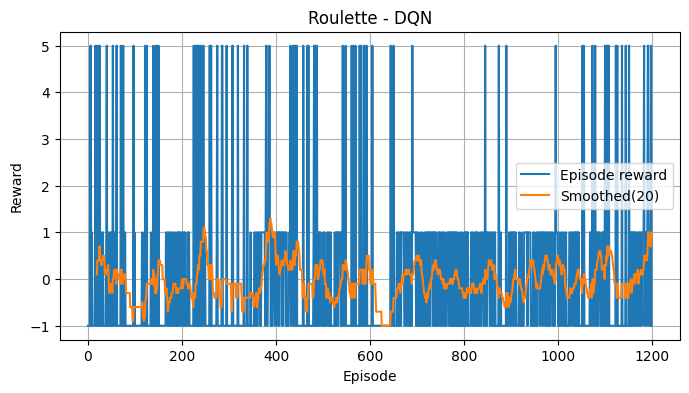

In [ ]:
# Simple Roulette environment (single-step episodes)
from gym import spaces

class SimpleRouletteEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(8)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)
    def reset(self):
        return np.array([0.0], dtype=np.float32)
    def step(self, action):
        pocket = random.randint(0,5)
        r = 0.0
        if 0 <= action <= 5:
            r = 5.0 if action == pocket else -1.0
        elif action == 6:
            r = 1.0 if pocket % 2 == 0 else -1.0
        elif action == 7:
            r = 1.0 if pocket % 2 == 1 else -1.0
        return np.array([0.0], dtype=np.float32), float(r), True, {}

# Register and create
gym.envs.registration.register(id='SimpleRoulette-v0', entry_point=SimpleRouletteEnv)
r_env = gym.make('SimpleRoulette-v0')

# Q-Learning (trivial state => Q is vector)
def train_q_learning_roulette(episodes=2000):
    Q = np.zeros(r_env.action_space.n)
    alpha = 0.1
    eps = 1.0; min_eps = 0.05; decay = 0.995
    rewards = []
    for ep in range(episodes):
        _ = r_env.reset()   # must reset each episode
        if random.random() < eps:
            a = r_env.action_space.sample()
        else:
            a = int(np.argmax(Q))
        _, r, _, _ = r_env.step(a)
        Q[a] += alpha * (r - Q[a])
        rewards.append(r)
        eps = max(min_eps, eps * decay)
        if (ep+1) % 500 == 0:
            print(f"[Roulette Q] Ep {ep+1}, avg_last500={np.mean(rewards[-500:]):.3f}")
    return Q, rewards

print("Training Q-Learning on Roulette...")
roulette_Q, roulette_q_rewards = train_q_learning_roulette(episodes=2000)
plot_learning_curve(roulette_q_rewards, "Roulette - Q-Learning")

# DQN for roulette (tiny network)
class SmallNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim)
        )
    def forward(self, x):
        return self.net(x)

def train_dqn_roulette(episodes=1200, batch_size=64):
    env_local = gym.make('SimpleRoulette-v0')
    model = SmallNet(env_local.observation_space.shape[0], env_local.action_space.n).to(device)
    target = SmallNet(env_local.observation_space.shape[0], env_local.action_space.n).to(device)
    target.load_state_dict(model.state_dict())
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    buffer = deque(maxlen=5000)
    eps = 1.0; eps_end = 0.05; eps_decay = 0.995
    rewards = []

    for ep in range(episodes):
        _ = env_local.reset()
        s = np.array([0.0], dtype=np.float32)
        s_t = torch.tensor(s, dtype=torch.float32, device=device)
        if random.random() < eps:
            a = env_local.action_space.sample()
        else:
            with torch.no_grad():
                a = int(torch.argmax(model(s_t)).item())
        s2, r, done, _ = env_local.step(a)
        buffer.append((s, a, r, s2, done))

        if len(buffer) >= batch_size:
            batch = random.sample(buffer, batch_size)
            s_b = torch.tensor([b[0] for b in batch], dtype=torch.float32, device=device)
            a_b = torch.tensor([b[1] for b in batch], dtype=torch.int64, device=device).unsqueeze(1)
            r_b = torch.tensor([b[2] for b in batch], dtype=torch.float32, device=device).unsqueeze(1)
            qvals = model(s_b).gather(1, a_b)
            # For this simple single-step env, target is just r
            loss = nn.functional.mse_loss(qvals, r_b)
            optimizer.zero_grad(); loss.backward(); optimizer.step()

        rewards.append(r)
        eps = max(eps_end, eps * eps_decay)
        if (ep+1) % 200 == 0:
            target.load_state_dict(model.state_dict())
            print(f"[Roulette DQN] Ep {ep+1}, last_r={r:.2f}, eps={eps:.3f}")

    return model, rewards

print("Training DQN on Roulette (short run)...")
roulette_dqn_model, roulette_dqn_rewards = train_dqn_roulette(episodes=1200, batch_size=64)
plot_learning_curve(roulette_dqn_rewards, "Roulette - DQN")


Default graph (directed weighted): {0: {1: 1, 2: 4}, 1: {2: 2, 3: 5}, 2: {3: 1}, 3: {}}
Training Q-Learning on Shortest Path (default graph)...


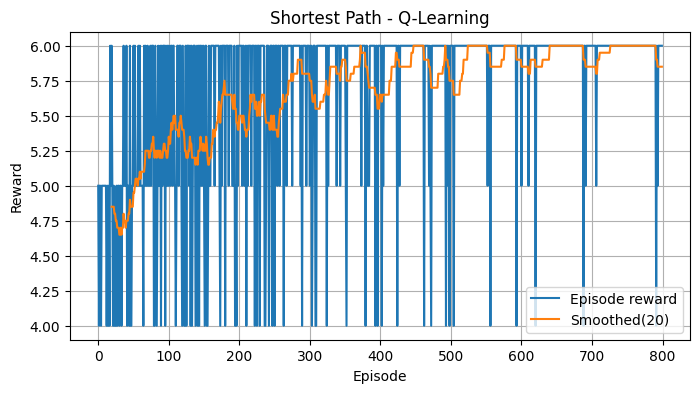

Training DQN on Shortest Path (short run)...
[SP DQN] Episode 200/800  ep_r=4.00 eps=0.367
[SP DQN] Episode 400/800  ep_r=4.00 eps=0.135
[SP DQN] Episode 600/800  ep_r=5.00 eps=0.050
[SP DQN] Episode 800/800  ep_r=6.00 eps=0.050


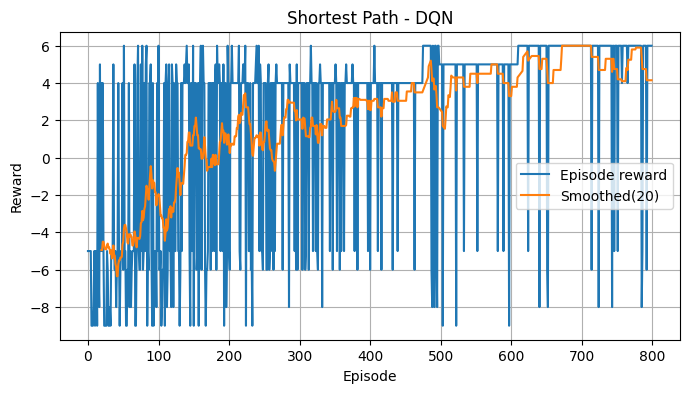

In [ ]:
# Shortest Path on a user-input graph (default provided)
default_graph = {
    0: {1:1, 2:4},
    1: {2:2, 3:5},
    2: {3:1},
    3: {}
}
print("Default graph (directed weighted):", default_graph)

def train_q_learning_shortestpath(graph, start=0, goal=3, episodes=800):
    Q = {n: {nbr: 0.0 for nbr in graph[n].keys()} for n in graph.keys()}
    alpha = 0.2; gamma = 0.99
    eps = 1.0; min_eps = 0.05; decay = 0.995
    rewards = []
    for ep in range(episodes):
        s = start
        ep_r = 0.0
        steps = 0
        while True:
            if not graph[s]:
                break
            actions = list(graph[s].keys())
            if random.random() < eps:
                a = random.choice(actions)
            else:
                a = max(actions, key=lambda nb: Q[s][nb])
            w = graph[s][a]
            r = -w + (10.0 if a == goal else 0.0)
            # next state's best Q
            next_best = max(Q[a].values()) if graph[a] else 0.0
            Q[s][a] += alpha * (r + gamma * next_best - Q[s][a])
            s = a
            ep_r += r
            steps += 1
            if s == goal or steps > 50:
                break
        eps = max(min_eps, eps * decay)
        rewards.append(ep_r)
    return Q, rewards

print("Training Q-Learning on Shortest Path (default graph)...")
sp_q_values, sp_q_rewards = train_q_learning_shortestpath(default_graph, start=0, goal=3, episodes=800)
plot_learning_curve(sp_q_rewards, "Shortest Path - Q-Learning")

# DQN approach: states = one-hot nodes, actions = choose a node (mask invalid)
class SPDQN(nn.Module):
    def __init__(self, n_states, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_states, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
    def forward(self, x):
        return self.net(x)

def train_dqn_shortestpath(graph, start=0, goal=3, episodes=800, batch_size=64):
    nodes = sorted(graph.keys())
    idx = {n:i for i,n in enumerate(nodes)}
    n_states = len(nodes)
    n_actions = len(nodes)  # action picks a node (we will mask invalid)
    model = SPDQN(n_states, n_actions).to(device)
    target = SPDQN(n_states, n_actions).to(device)
    target.load_state_dict(model.state_dict())
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    buffer = deque(maxlen=20000)
    eps = 1.0; min_eps = 0.05; decay = 0.995
    rewards = []

    for ep in range(episodes):
        s = start
        ep_r = 0.0
        steps = 0
        while True:
            s_vec = np.zeros(n_states, dtype=np.float32); s_vec[idx[s]] = 1.0
            if random.random() < eps:
                a_idx = random.randrange(n_actions)
            else:
                with torch.no_grad():
                    qvals = model(torch.tensor(s_vec, dtype=torch.float32, device=device))
                    q_np = qvals.cpu().numpy()
                    # mask invalid moves
                    mask = np.array([ -1e9 if nodes[i] not in graph[s] else 0.0 for i in range(n_actions)], dtype=np.float32)
                    a_idx = int(np.argmax(q_np + mask))
            a_node = nodes[a_idx]
            if a_node not in graph[s]:
                # invalid action: penalize and end episode step
                r = -5.0
                buffer.append((s_vec, a_idx, r, s_vec, True))
                ep_r += r
                break
            w = graph[s][a_node]
            r = -w + (10.0 if a_node == goal else 0.0)
            s2_vec = np.zeros(n_states, dtype=np.float32); s2_vec[idx[a_node]] = 1.0
            done = (a_node == goal)
            buffer.append((s_vec, a_idx, r, s2_vec, done))
            ep_r += r
            s = a_node
            steps += 1
            if done or steps > 50:
                break

            # Train from buffer
            if len(buffer) >= batch_size:
                batch = random.sample(buffer, batch_size)
                s_b = torch.tensor([b[0] for b in batch], dtype=torch.float32, device=device)
                a_b = torch.tensor([b[1] for b in batch], dtype=torch.int64, device=device).unsqueeze(1)
                r_b = torch.tensor([b[2] for b in batch], dtype=torch.float32, device=device).unsqueeze(1)
                s2_b = torch.tensor([b[3] for b in batch], dtype=torch.float32, device=device)
                done_b = torch.tensor([b[4] for b in batch], dtype=torch.float32, device=device).unsqueeze(1)

                qvals = model(s_b).gather(1, a_b)
                with torch.no_grad():
                    next_q = target(s2_b)
                    # For each s2 in batch, mask invalid actions before taking max:
                    next_q_np = next_q.cpu().numpy()
                    max_next = []
                    for i in range(next_q_np.shape[0]):
                        s2_node_idx = int(np.argmax(s2_b[i].cpu().numpy()))
                        s2_node = nodes[s2_node_idx]
                        if not graph[s2_node]:
                            max_next.append(0.0)
                        else:
                            legal_idxs = [idx[nn] for nn in graph[s2_node].keys()]
                            max_next.append(float(next_q[i, legal_idxs].max().cpu().numpy()))
                    max_next = torch.tensor(max_next, dtype=torch.float32, device=device).unsqueeze(1)
                expected = r_b + 0.99 * max_next * (1 - done_b)
                loss = nn.functional.mse_loss(qvals, expected)
                optimizer.zero_grad(); loss.backward(); optimizer.step()

        rewards.append(ep_r)
        eps = max(min_eps, eps * decay)
        if (ep+1) % 200 == 0:
            target.load_state_dict(model.state_dict())
            print(f"[SP DQN] Episode {ep+1}/{episodes}  ep_r={ep_r:.2f} eps={eps:.3f}")

    return model, rewards

print("Training DQN on Shortest Path (short run)...")
sp_dqn_model, sp_dqn_rewards = train_dqn_shortestpath(default_graph, start=0, goal=3, episodes=800, batch_size=64)
plot_learning_curve(sp_dqn_rewards, "Shortest Path - DQN")


In [ ]:
# --- Evaluation policies ---
mc_q_policy = lambda s: int(np.argmax(q_table[discretize(s)]))
mc_dqn_policy = lambda s: int(torch.argmax(mc_dqn_model(torch.tensor(s, dtype=torch.float32, device=device))).item())

# MountainCar eval
mc_q_mean, mc_q_std = evaluate_policy(env, mc_q_policy, episodes=10)
mc_dqn_mean, mc_dqn_std = evaluate_policy(gym.make("MountainCar-v0"), mc_dqn_policy, episodes=10)

# Roulette eval
roulette_q_policy = lambda s: int(np.argmax(roulette_Q))
def roulette_dqn_policy(s):
    s_t = torch.tensor(s, dtype=torch.float32, device=device)
    with torch.no_grad():
        return int(torch.argmax(roulette_dqn_model(s_t)).item())

rq_q_mean, _ = evaluate_policy(r_env, roulette_q_policy, episodes=200)
rq_dqn_mean, _ = evaluate_policy(gym.make("SimpleRoulette-v0"), roulette_dqn_policy, episodes=200)

# Shortest path eval helpers
def eval_sp_q(graph, Q, start=0, goal=3, trials=50):
    rewards = []; lengths = []
    for _ in range(trials):
        s = start; total = 0.0; l = 0
        while s != goal and l < 50:
            if not graph[s]:
                break
            a = max(graph[s].keys(), key=lambda nb: Q[s].get(nb, -1e9))
            total += -graph[s][a] + (10.0 if a == goal else 0.0)
            s = a; l += 1
        rewards.append(total); lengths.append(l)
    return np.mean(rewards), np.mean(lengths)

def eval_sp_dqn(graph, model, start=0, goal=3, trials=50):
    nodes = sorted(graph.keys()); idx = {n:i for i,n in enumerate(nodes)}
    rewards = []; lengths = []
    for _ in range(trials):
        s = start; total = 0.0; l = 0
        while s != goal and l < 50:
            sv = np.zeros(len(nodes), dtype=np.float32); sv[idx[s]] = 1.0
            with torch.no_grad():
                q = model(torch.tensor(sv, dtype=torch.float32, device=device)).cpu().numpy()
            mask = np.array([ -1e9 if nodes[i] not in graph[s] else 0.0 for i in range(len(nodes)) ], dtype=np.float32)
            a_idx = int(np.argmax(q + mask))
            a_node = nodes[a_idx]
            if a_node not in graph[s]:
                total += -5.0; break
            total += -graph[s][a_node] + (10.0 if a_node == goal else 0.0)
            s = a_node; l += 1
        rewards.append(total); lengths.append(l)
    return np.mean(rewards), np.mean(lengths)

sp_q_mean, sp_q_len = eval_sp_q(default_graph, sp_q_values, start=0, goal=3)
sp_dqn_mean, sp_dqn_len = eval_sp_dqn(default_graph, sp_dqn_model, start=0, goal=3)

# --- Comparison table ---
table = [
    ["Environment", "Method", "Avg Reward", "Std/Notes", "Avg Path Len"],
    ["MountainCar", "Q-Learning", f"{mc_q_mean:.2f}", f"{mc_q_std:.2f}", "-"],
    ["MountainCar", "DQN", f"{mc_dqn_mean:.2f}", f"{mc_dqn_std:.2f}", "-"],
    ["Roulette", "Q-Learning", f"{rq_q_mean:.2f}", "-", "-"],
    ["Roulette", "DQN", f"{rq_dqn_mean:.2f}", "-", "-"],
    ["ShortestPath", "Q-Learning", f"{sp_q_mean:.2f}", "-", f"{sp_q_len:.2f}"],
    ["ShortestPath", "DQN", f"{sp_dqn_mean:.2f}", "-", f"{sp_dqn_len:.2f}"]
]
print(tabulate(table, headers="firstrow", tablefmt="github"))

# --- Save outputs and create PDF report ---
os.makedirs("outputs", exist_ok=True)
# save plots
plt.figure(); plt.plot(mc_q_rewards); plt.title("MC Q-Learning"); plt.savefig("outputs/mc_q_rewards.png"); plt.close()
plt.figure(); plt.plot(mc_dqn_rewards); plt.title("MC DQN"); plt.savefig("outputs/mc_dqn_rewards.png"); plt.close()
plt.figure(); plt.plot(roulette_q_rewards); plt.title("Roulette Q"); plt.savefig("outputs/r_q_rewards.png"); plt.close()
plt.figure(); plt.plot(roulette_dqn_rewards); plt.title("Roulette DQN"); plt.savefig("outputs/r_dqn_rewards.png"); plt.close()
plt.figure(); plt.plot(sp_q_rewards); plt.title("SP Q"); plt.savefig("outputs/sp_q_rewards.png"); plt.close()
plt.figure(); plt.plot(sp_dqn_rewards); plt.title("SP DQN"); plt.savefig("outputs/sp_dqn_rewards.png"); plt.close()

# save DQN models (optional)
torch.save(mc_dqn_model.state_dict(), "outputs/mc_dqn.pt")
torch.save(roulette_dqn_model.state_dict(), "outputs/roulette_dqn.pt")
torch.save(sp_dqn_model.state_dict(), "outputs/sp_dqn.pt")


| Environment   | Method     |   Avg Reward | Std/Notes   | Avg Path Len   |
|---------------|------------|--------------|-------------|----------------|
| MountainCar   | Q-Learning |      -167.7  | 16.37       | -              |
| MountainCar   | DQN        |      -200    | 0.00        | -              |
| Roulette      | Q-Learning |         0.2  | -           | -              |
| Roulette      | DQN        |        -0.25 | -           | -              |
| ShortestPath  | Q-Learning |         6    | -           | 3.00           |
| ShortestPath  | DQN        |         6    | -           | 3.00           |


In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np

env = gym.make("MountainCar-v0", render_mode="rgb_array")

frames = []
state, _ = env.reset()
done = False
for _ in range(200):
    action = np.argmax(q_table[state])  # Use your learned Q-table
    state, reward, terminated, truncated, _ = env.step(action)
    frames.append(env.render())
    if terminated or truncated:
        break

env.close()

# Save as GIF (works everywhere)
import imageio
imageio.mimsave("mountaincar_agent.gif", frames, fps=30)
print("✅ Saved 'mountaincar_agent.gif' successfully!")


/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_r

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices